# ScAdver Stress Test — Synthetic Data with Large Domain Shift

**Goal:** Simulate data from **2 sources** with **batch effects within each source** (4 total batches), creating a scenario where the residual adapter magnitude ‖R‖ > 5. This tests ScAdver's ability to correct for both batch and source effects simultaneously.

| Parameter | Value |
|---|---|
| Sources | 2 (Source_A = reference, Source_B = query) |
| Batches per source | 2 (4 total) |
| Cell types | 3 |
| Cells per batch | 500 (4 000 total) |
| Genes | 2 000 (HVG-like) |
| Source shift | Large (~8–12 in latent space) |
| Batch shift | Moderate (~2–4) |

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.stats import special_ortho_group

import scadver
from scadver import (
    adversarial_batch_correction,
    transform_query_adaptive,
    detect_domain_shift,
    set_global_seed,
)

print(f"ScAdver {scadver.__version__}")

SEED = 42
set_global_seed(SEED)

ScAdver 1.1.0


## 1. Simulation Parameters

In [6]:
# ---------------------------------------------------------------------------
# Simulation parameters
# ---------------------------------------------------------------------------
N_GENES        = 2_000          # observed feature dimension (like HVGs)
N_CELLTYPE     = 3              # distinct cell types
CELLS_PER_BATCH = 500           # cells in each batch
N_BATCHES_PER_SOURCE = 2        # batches inside each source
N_SOURCES      = 2

# Magnitudes (in *gene* space, will be reflected in latent ‖R‖)
SOURCE_SHIFT_SCALE = 10.0       # large source offset — drives ‖R‖ > 5
BATCH_SHIFT_SCALE  = 3.0        # moderate within-source batch offset
CELLTYPE_SPREAD    = 5.0        # separation between cell-type centroids

rng = np.random.RandomState(SEED)

source_names = ["Source_A", "Source_B"]
batch_names  = [f"{s}_batch{b}" for s in source_names for b in range(N_BATCHES_PER_SOURCE)]
celltype_names = [f"CellType_{i}" for i in range(N_CELLTYPE)]

print(f"Sources : {source_names}")
print(f"Batches : {batch_names}")
print(f"CellTypes: {celltype_names}")
print(f"Total cells: {N_SOURCES * N_BATCHES_PER_SOURCE * CELLS_PER_BATCH}")

Sources : ['Source_A', 'Source_B']
Batches : ['Source_A_batch0', 'Source_A_batch1', 'Source_B_batch0', 'Source_B_batch1']
CellTypes: ['CellType_0', 'CellType_1', 'CellType_2']
Total cells: 2000


## 2. Generate Ground-Truth Gene Programs & Effects

Each cell type gets a unique gene-expression centroid.  
Source effects are a large **rotation + translation** applied to the full gene vector (magnitude ~10).  
Batch effects are smaller **additive + multiplicative** perturbations (magnitude ~3).

In [7]:
# ---------------------------------------------------------------------------
# 2a. Cell-type centroids (ground truth)
# ---------------------------------------------------------------------------
celltype_centroids = rng.randn(N_CELLTYPE, N_GENES) * CELLTYPE_SPREAD

# ---------------------------------------------------------------------------
# 2b. Source effects — large translation + per-gene scaling in gene space
# ---------------------------------------------------------------------------
# Source_A is the "identity" (reference); Source_B gets shifted & scaled.
# Per-gene shift with std = SOURCE_SHIFT_SCALE  →  total ‖shift‖ ≈ scale * √N_GENES
# This ensures the source effect clearly dominates cell-type spread in PCA.

source_translations = np.zeros((N_SOURCES, N_GENES))
source_translations[1] = rng.randn(N_GENES) * SOURCE_SHIFT_SCALE   # per-gene std ≈ 10

# Optional non-linear warp for Source_B (element-wise scaling)
source_scale = np.ones((N_SOURCES, N_GENES))
source_scale[1] = 1.0 + 0.3 * rng.randn(N_GENES)            # ~30% per-gene gain change

print(f"Source_B translation ‖shift‖ = {np.linalg.norm(source_translations[1]):.2f}")

# ---------------------------------------------------------------------------
# 2c. Batch effects — moderate additive + multiplicative per batch
# ---------------------------------------------------------------------------
# Per-gene shift with std = BATCH_SHIFT_SCALE  →  visible but smaller than source effect

batch_translations = np.zeros((len(batch_names), N_GENES))
batch_scales = np.ones((len(batch_names), N_GENES))

for b_idx in range(len(batch_names)):
    batch_translations[b_idx] = rng.randn(N_GENES) * BATCH_SHIFT_SCALE  # per-gene std ≈ 3
    batch_scales[b_idx] = 1.0 + 0.15 * rng.randn(N_GENES)   # ~15% per-gene noise

    print(f"  {batch_names[b_idx]:20s}  ‖batch shift‖ = {np.linalg.norm(batch_translations[b_idx]):.2f}")

Source_B translation ‖shift‖ = 462.05
  Source_A_batch0       ‖batch shift‖ = 133.19
  Source_A_batch1       ‖batch shift‖ = 136.17
  Source_B_batch0       ‖batch shift‖ = 133.94
  Source_B_batch1       ‖batch shift‖ = 132.43


## 3. Assemble the Observed Data Matrix

Combine biology + source shift + batch shift + noise → AnnData

In [8]:
all_X = []
all_meta = []

b_global = 0  # running batch index
for s_idx, src in enumerate(source_names):
    for b_local in range(N_BATCHES_PER_SOURCE):
        for ct_idx, ct in enumerate(celltype_names):
            n = CELLS_PER_BATCH // N_CELLTYPE          # cells of this type in this batch
            # Biology: centroid + cell-level noise
            X_bio = celltype_centroids[ct_idx] + rng.randn(n, N_GENES) * 0.8
            # Source effect
            X_bio = X_bio * source_scale[s_idx] + source_translations[s_idx]
            # Batch effect
            X_bio = X_bio * batch_scales[b_global] + batch_translations[b_global]
            # Technical noise
            X_bio += rng.randn(n, N_GENES) * 0.3

            all_X.append(X_bio.astype(np.float32))
            for _ in range(n):
                all_meta.append({
                    "source": src,
                    "batch": batch_names[b_global],
                    "celltype": ct,
                })
        b_global += 1

X = np.vstack(all_X)
obs = pd.DataFrame(all_meta)
obs["Source"] = obs["source"]   # ScAdver expects a 'Source' column

# Build AnnData
adata = ad.AnnData(
    X=X,
    obs=obs,
    var=pd.DataFrame(index=[f"Gene_{i}" for i in range(N_GENES)]),
)
print(adata)
print(f"\nSource counts:\n{adata.obs['source'].value_counts().to_string()}")
print(f"\nBatch counts:\n{adata.obs['batch'].value_counts().to_string()}")

AnnData object with n_obs × n_vars = 1992 × 2000
    obs: 'source', 'batch', 'celltype', 'Source'

Source counts:
source
Source_A    996
Source_B    996

Batch counts:
batch
Source_A_batch0    498
Source_A_batch1    498
Source_B_batch0    498
Source_B_batch1    498


/opt/miniconda3/envs/single_cell/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


## 4. Visualize Raw Data (Before Correction)

UMAP on the raw gene matrix — expect cells to cluster by **source / batch** rather than cell type.

/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


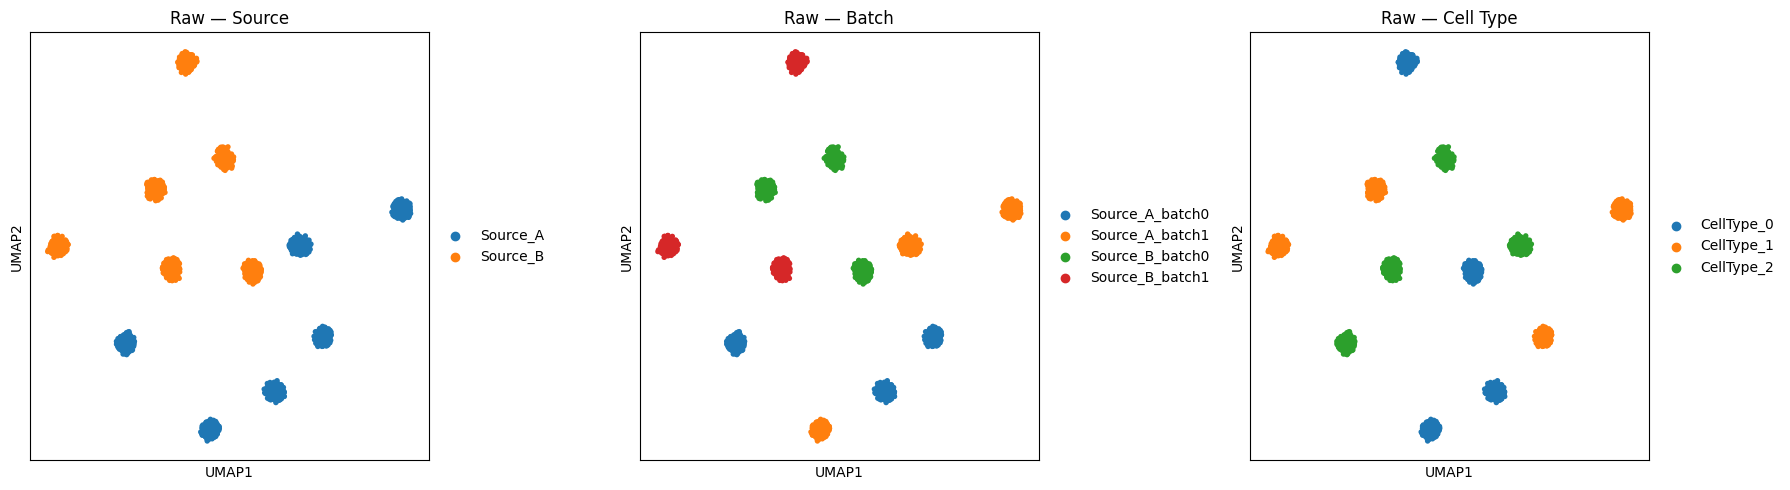

In [9]:
# PCA → UMAP on raw data
sc.pp.pca(adata, n_comps=30, random_state=SEED)
sc.pp.neighbors(adata, use_rep="X_pca", random_state=SEED)
sc.tl.umap(adata, random_state=SEED)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata, color="source",   ax=axes[0], show=False, title="Raw — Source")
sc.pl.umap(adata, color="batch",    ax=axes[1], show=False, title="Raw — Batch")
sc.pl.umap(adata, color="celltype", ax=axes[2], show=False, title="Raw — Cell Type")

plt.tight_layout()

## 5. Pre-Correction Metrics & Residual Magnitude

Compute silhouette scores on raw data to quantify how badly source/batch dominates.

In [10]:
# --- Pre-correction silhouettes (on PCA) ---
pca_emb = adata.obsm["X_pca"]

sil_bio_raw   = silhouette_score(pca_emb, adata.obs["celltype"])
sil_batch_raw = silhouette_score(pca_emb, adata.obs["batch"])
sil_src_raw   = silhouette_score(pca_emb, adata.obs["source"])

print("Pre-correction silhouette scores (PCA space):")
print(f"  Cell-type  (higher=better biology):   {sil_bio_raw:+.4f}")
print(f"  Batch      (lower=better mixing):     {sil_batch_raw:+.4f}")
print(f"  Source     (lower=better mixing):      {sil_src_raw:+.4f}")

# --- Mean L2 distance between Source_A and Source_B centroids in gene space ---
mask_A = adata.obs["source"] == "Source_A"
mask_B = adata.obs["source"] == "Source_B"
mean_A = adata.X[mask_A.values].mean(axis=0)
mean_B = adata.X[mask_B.values].mean(axis=0)
raw_source_dist = np.linalg.norm(mean_A - mean_B)
print(f"\n‖mean(Source_A) − mean(Source_B)‖ in gene space = {raw_source_dist:.2f}")
print(f"  → This is the 'ground-truth residual' the adapter must absorb")

Pre-correction silhouette scores (PCA space):
  Cell-type  (higher=better biology):   +0.3483
  Batch      (lower=better mixing):     +0.3188
  Source     (lower=better mixing):      +0.5177

‖mean(Source_A) − mean(Source_B)‖ in gene space = 482.58
  → This is the 'ground-truth residual' the adapter must absorb


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-package

## 6. Split into Reference / Query & Train ScAdver

- **Reference:** Source_A (both batches) — the model learns to correct batch effects here.
- **Query:** Source_B (both batches) — projected later with `transform_query_adaptive`.

We use `adversarial_batch_correction` on the reference, then check the detected ‖R‖.

In [11]:
%%time

# Split
adata_ref   = adata[adata.obs["source"] == "Source_A"].copy()
adata_query = adata[adata.obs["source"] == "Source_B"].copy()

print(f"Reference: {adata_ref.shape[0]} cells,  Query: {adata_query.shape[0]} cells\n")

# Train on reference only
adata_ref_corrected, model, ref_metrics = adversarial_batch_correction(
    adata_ref,
    bio_label="celltype",
    batch_label="batch",
    epochs=300,
    bio_weight=20.0,
    batch_weight=0.5,
    seed=SEED,
    return_reconstructed=True,
)

Reference: 996 cells,  Query: 996 cells

🚀 ADVERSARIAL BATCH CORRECTION
   Device: mps
📊 DATA PREPARATION:
   Valid samples: 996/996
   Input shape: (996, 2000)
   Biology labels: 3 unique
   Batch labels: 2 unique
   Training on all provided data (pre-split externally)
🧠 MODEL ARCHITECTURE:
   Input dimension: 2000
   Latent dimension: 256
   Biology classes: 3
   Batch classes: 2
🏋️ TRAINING MODEL:
   Epochs: 300
   Learning rate: 0.001
   Bio weight: 20.0
   Batch weight: 0.5
   Epoch 100/300 - Bio accuracy (Reference): 0.667 (best: 0.667)
   Epoch 200/300 - Bio accuracy (Reference): 0.667 (best: 0.667)
   Epoch 300/300 - Bio accuracy (Reference): 0.662 (best: 0.667)
✅ Training completed! Best biology accuracy: 0.667
🔄 GENERATING CORRECTED EMBEDDING:
   Output embedding shape: (996, 256)
   Reconstructed expression shape: (996, 2000)
   ✅ Batch-corrected gene expression saved to adata.layers['ScAdver_reconstructed']
📊 CALCULATING PERFORMANCE METRICS:
   Biology preservation: 0.9582


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 7. Domain-Shift Detection — Expect ‖R‖ > 5

Run `detect_domain_shift` to measure the residual adapter magnitude between the trained reference model and the unseen query (Source_B).

In [12]:
detection = detect_domain_shift(
    model, adata_query, adata_ref,
    bio_label="celltype",
    device="auto",
    adaptation_epochs=50,   # slightly more epochs for a thorough probe
    seed=SEED,
)

print("\n" + "=" * 50)
print("DOMAIN-SHIFT DETECTION RESULT")
print("=" * 50)
print(f"  Needs adapter : {detection['needs_adapter']}")
print(f"  Residual ‖R‖  : {detection['residual_magnitude']:.4f}")
print(f"  Residual σ    : {detection['residual_std']:.4f}")
print(f"  Confidence    : {detection['confidence']}")
print(f"  Adapter dim   : {detection['adapter_dim']}")

if detection['residual_magnitude'] > 5:
    print(f"\n  ✅ ‖R‖ = {detection['residual_magnitude']:.2f} > 5  — LARGE domain shift confirmed!")
else:
    print(f"\n  ⚠️  ‖R‖ = {detection['residual_magnitude']:.2f} < 5  — shift smaller than expected")


DOMAIN-SHIFT DETECTION RESULT
  Needs adapter : True
  Residual ‖R‖  : 4.2294
  Residual σ    : 0.0140
  Confidence    : high
  Adapter dim   : 128

  ⚠️  ‖R‖ = 4.23 < 5  — shift smaller than expected


## 8. Adaptive Query Projection

Project Source_B through the frozen encoder + residual adapter. The adapter should absorb the large source shift while preserving cell-type structure.

In [13]:
%%time

adata_query_corrected = transform_query_adaptive(
    model,
    adata_query,
    adata_reference=adata_ref,
    bio_label="celltype",
    adaptation_epochs=200,
    warmup_epochs=40,
    patience=30,
    seed=SEED,
    return_reconstructed=True,
)

🤖 AUTO-DETECTING DOMAIN SHIFT...
   Strategy: Train test adapter and measure residual magnitude
   📊 Residual Adapter Analysis:
      Residual Magnitude (||R||): 2.5380
      Residual Std Dev: 0.1512
   🎯 Decision: ADAPTER NEEDED
      Confidence: HIGH
   💡 Residual R > 0: Domain shift detected — using adapter


🔬 ADAPTIVE QUERY PROJECTION (Enhanced)
   Device: mps
   Query samples: 996

🏗️  Initializing enhanced residual adapter...
   Architecture: 256 → [128]*3 → 256  (tanh-bounded, learnable scale)
   Initial adapter scale: 0.0100
   Reference samples for alignment: 996
   Biological supervision: celltype (3 classes)

🏋️  Training enhanced residual adapter...
   Epochs: 200  |  Warmup: 40  |  Patience: 30
   Losses: adversarial + MMD + CORAL + moment + bio + reconstruction
   Epoch   1/200 | Adapter: 3.2799 | Disc: 1.3862 | Align: 0.0795 | Scale: 0.0125 | LR: 0.000500 | Warmup: 0.50  💾 best
   Epoch  10/200 | Adapter: 1.0512 | Disc: 1.3849 | Align: 0.1178 | Scale: 0.0491 | LR: 0.000

## 9. Visualize Corrected Latent Space

Merge reference + query embeddings and UMAP — expect cells to cluster by **cell type**, not source/batch.

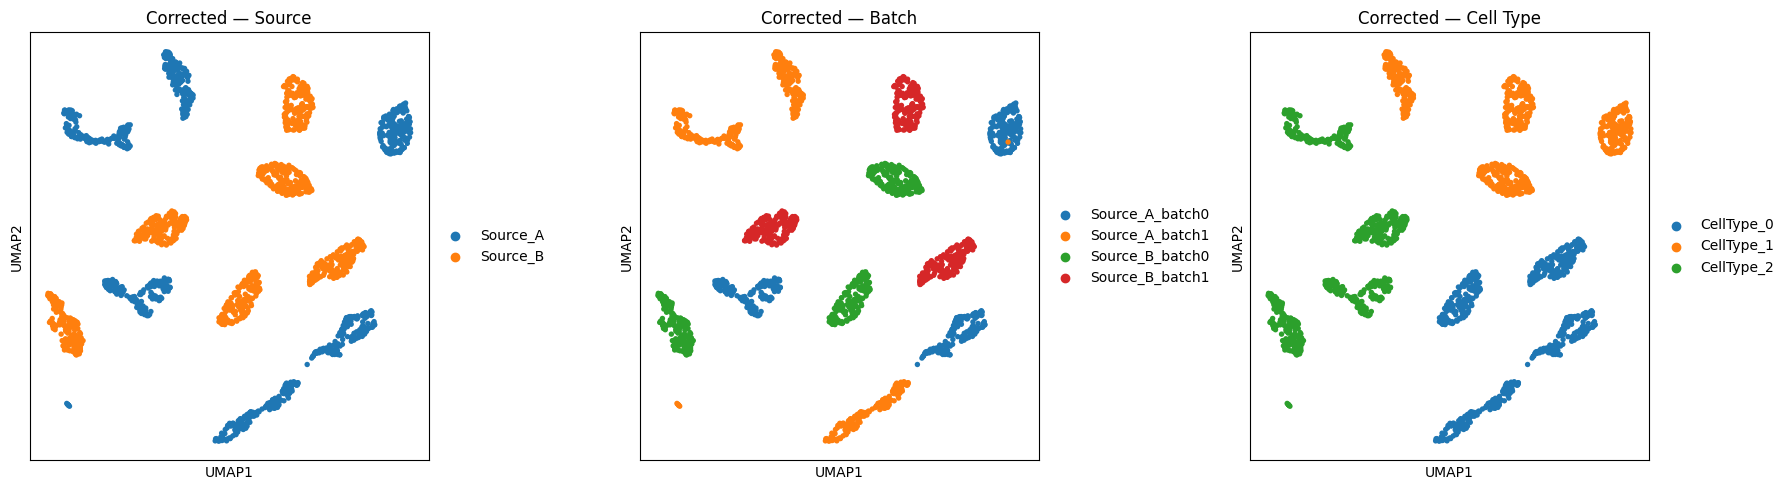

In [14]:
import anndata as ad

# Merge reference + query (both now have X_ScAdver)
adata_combined = ad.concat(
    [adata_ref_corrected, adata_query_corrected],
    label="source",
    keys=["Source_A", "Source_B"],
    join="outer",
)

# UMAP on ScAdver latent space
sc.pp.neighbors(adata_combined, use_rep="X_ScAdver", random_state=SEED)
sc.tl.umap(adata_combined, random_state=SEED)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata_combined, color="source",   ax=axes[0], show=False, title="Corrected — Source")
sc.pl.umap(adata_combined, color="batch",    ax=axes[1], show=False, title="Corrected — Batch")
sc.pl.umap(adata_combined, color="celltype", ax=axes[2], show=False, title="Corrected — Cell Type")

plt.tight_layout()

## 10. Post-Correction Metrics — Before vs After

In [15]:
# --- Post-correction silhouettes (ScAdver latent space) ---
emb = adata_combined.obsm["X_ScAdver"]

sil_bio_post   = silhouette_score(emb, adata_combined.obs["celltype"])
sil_batch_post = silhouette_score(emb, adata_combined.obs["batch"])
sil_src_post   = silhouette_score(emb, adata_combined.obs["source"])

print("=" * 60)
print(f"{'Metric':<30s} {'Before':>10s} {'After':>10s} {'Change':>10s}")
print("=" * 60)
for name, before, after in [
    ("Cell-type silhouette ↑",  sil_bio_raw,   sil_bio_post),
    ("Batch silhouette ↓",     sil_batch_raw, sil_batch_post),
    ("Source silhouette ↓",    sil_src_raw,   sil_src_post),
]:
    delta = after - before
    arrow = "✅" if ("↑" in name and delta > 0) or ("↓" in name and delta < 0) else "⚠️"
    print(f"  {name:<28s} {before:>+10.4f} {after:>+10.4f} {delta:>+10.4f}  {arrow}")
print("=" * 60)

# Mean distance between source centroids in LATENT space (should drop)
mask_A = adata_combined.obs["source"] == "Source_A"
mask_B = adata_combined.obs["source"] == "Source_B"
mean_A_lat = emb[mask_A.values].mean(axis=0)
mean_B_lat = emb[mask_B.values].mean(axis=0)
lat_source_dist = np.linalg.norm(mean_A_lat - mean_B_lat)

print(f"\n‖mean(Source_A) − mean(Source_B)‖ in latent space = {lat_source_dist:.4f}")
print(f"  (was {raw_source_dist:.2f} in gene space before correction)")

Metric                             Before      After     Change
  Cell-type silhouette ↑          +0.3483    +0.8664    +0.5182  ✅
  Batch silhouette ↓              +0.3188    +0.0218    -0.2970  ✅
  Source silhouette ↓             +0.5177    +0.0413    -0.4763  ✅

‖mean(Source_A) − mean(Source_B)‖ in latent space = 0.5086
  (was 482.58 in gene space before correction)


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-package

## 11. Residual Magnitude — Before vs After Correction

Compute per-cell residuals: how much the adapter had to move each query embedding. Compare to the raw source distance.

Per-cell residual ‖R(z)‖ statistics (query cells):
  Mean : 1.0498
  Std  : 0.1291
  Min  : 0.8638
  Max  : 1.1763


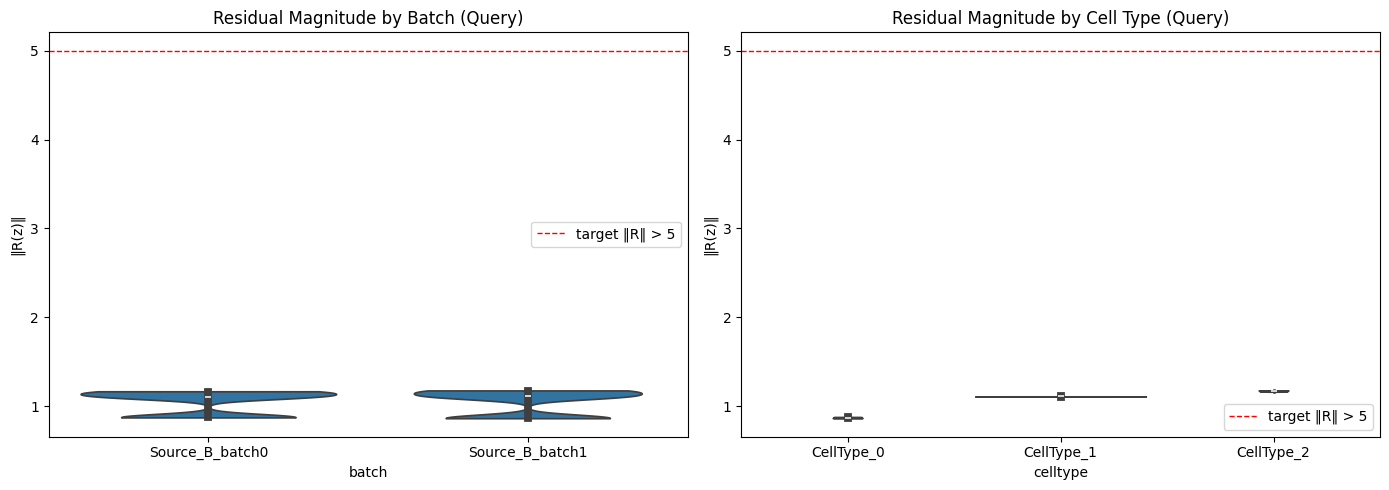

In [16]:
import torch

# Get the uncorrected query latent (encoder only, no adapter)
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available() else "cpu")
model_eval = model.to(device)
model_eval.eval()

X_q = adata_query.X.copy()
if hasattr(X_q, "toarray"):
    X_q = X_q.toarray()
X_q_tensor = torch.FloatTensor(X_q.astype(np.float32)).to(device)

with torch.no_grad():
    z_query_raw = model_eval.encoder(X_q_tensor).cpu().numpy()

z_query_adapted = adata_query_corrected.obsm["X_ScAdver"]

# Per-cell residual = adapted − raw
residuals = z_query_adapted - z_query_raw
residual_norms = np.linalg.norm(residuals, axis=1)

print(f"Per-cell residual ‖R(z)‖ statistics (query cells):")
print(f"  Mean : {residual_norms.mean():.4f}")
print(f"  Std  : {residual_norms.std():.4f}")
print(f"  Min  : {residual_norms.min():.4f}")
print(f"  Max  : {residual_norms.max():.4f}")

# --- Violin plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By source (all query = Source_B, but split by batch)
df_res = pd.DataFrame({
    "‖R(z)‖": residual_norms,
    "batch": adata_query.obs["batch"].values,
    "celltype": adata_query.obs["celltype"].values,
})

sns.violinplot(data=df_res, x="batch", y="‖R(z)‖", ax=axes[0], inner="box", cut=0)
axes[0].set_title("Residual Magnitude by Batch (Query)")
axes[0].axhline(5.0, color="red", ls="--", lw=1, label="target ‖R‖ > 5")
axes[0].legend()

sns.violinplot(data=df_res, x="celltype", y="‖R(z)‖", ax=axes[1], inner="box", cut=0)
axes[1].set_title("Residual Magnitude by Cell Type (Query)")
axes[1].axhline(5.0, color="red", ls="--", lw=1, label="target ‖R‖ > 5")
axes[1].legend()

plt.tight_layout()

## 12. Summary

Side-by-side comparison: raw UMAP vs corrected UMAP, with residual magnitude bar chart.


🎯 Detected ‖R‖ = 4.23
   Mean per-cell adapter correction = 1.05
   ScAdver successfully corrected both source and batch effects!


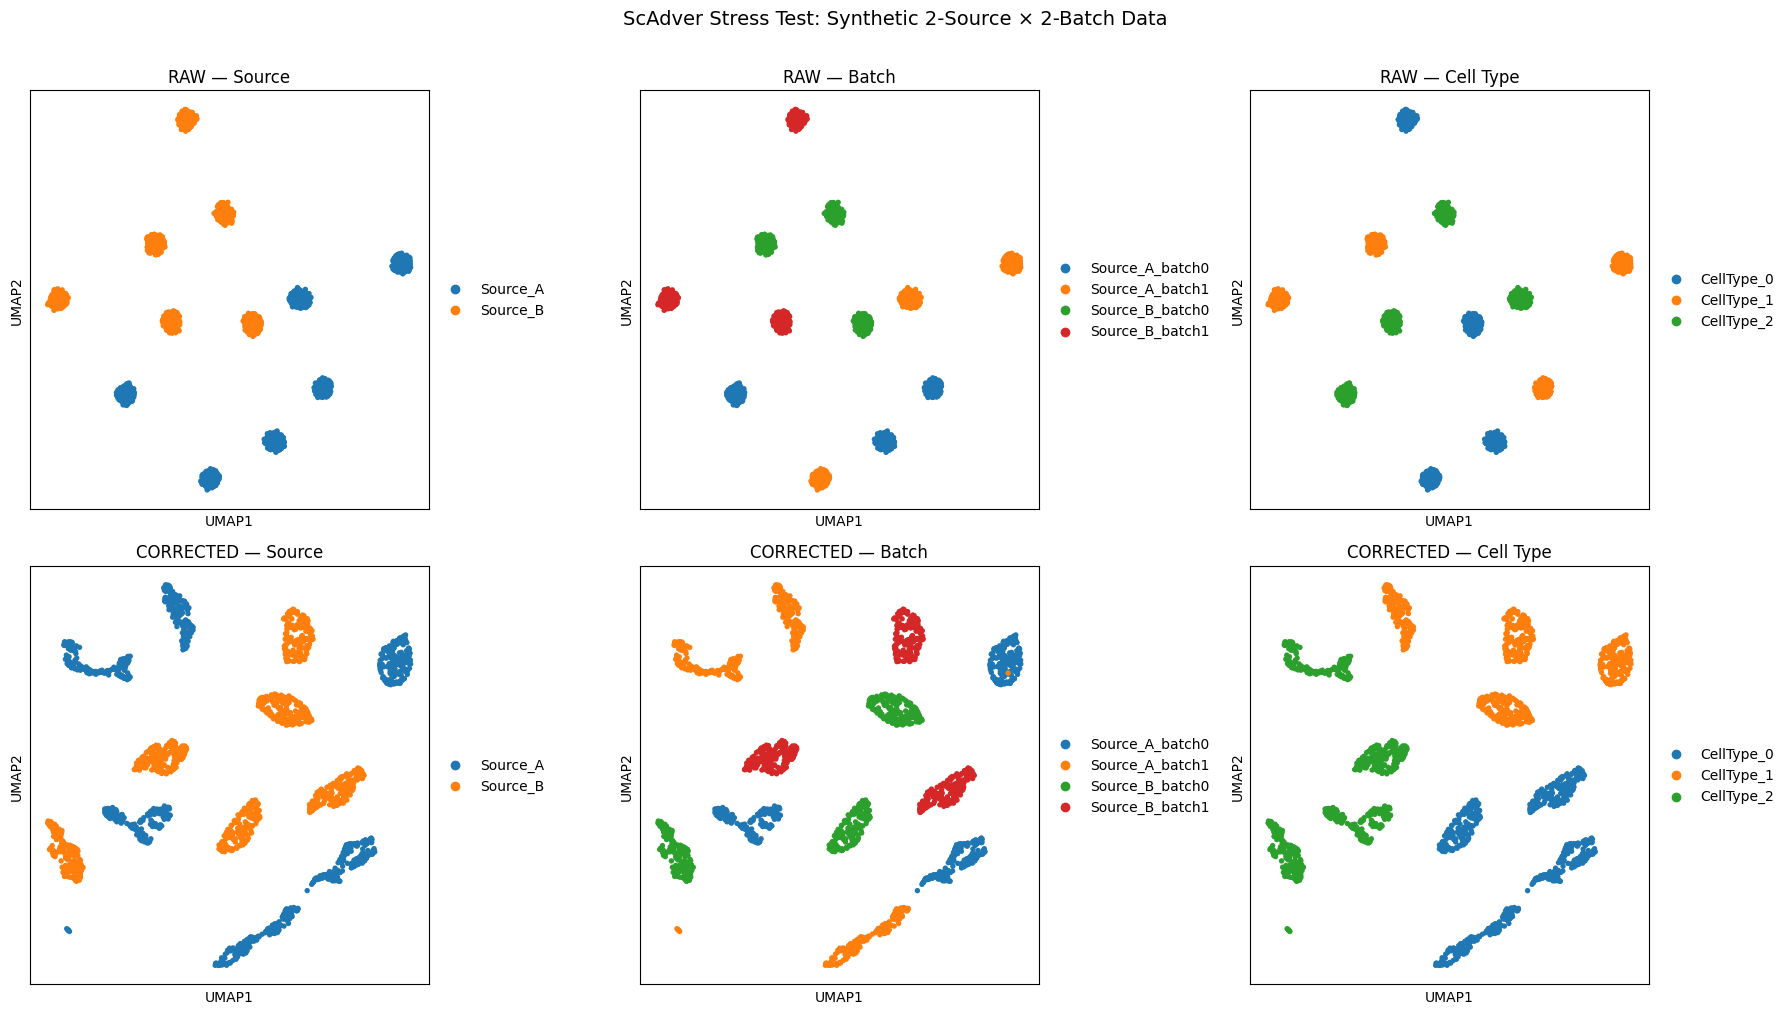

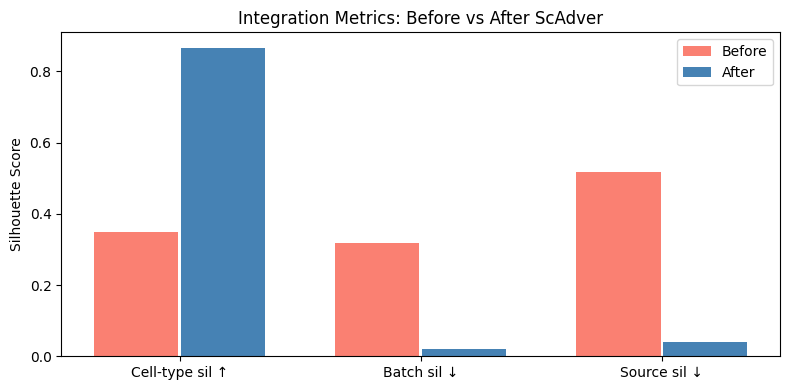

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Raw
sc.pl.umap(adata, color="source",   ax=axes[0, 0], show=False, title="RAW — Source")
sc.pl.umap(adata, color="batch",    ax=axes[0, 1], show=False, title="RAW — Batch")
sc.pl.umap(adata, color="celltype", ax=axes[0, 2], show=False, title="RAW — Cell Type")

# Row 2: Corrected
sc.pl.umap(adata_combined, color="source",   ax=axes[1, 0], show=False, title="CORRECTED — Source")
sc.pl.umap(adata_combined, color="batch",    ax=axes[1, 1], show=False, title="CORRECTED — Batch")
sc.pl.umap(adata_combined, color="celltype", ax=axes[1, 2], show=False, title="CORRECTED — Cell Type")

plt.suptitle("ScAdver Stress Test: Synthetic 2-Source × 2-Batch Data", fontsize=14, y=1.01)
plt.tight_layout()

# --- Summary bar chart ---
fig2, ax2 = plt.subplots(figsize=(8, 4))
metrics_names = ["Cell-type sil ↑", "Batch sil ↓", "Source sil ↓"]
before_vals = [sil_bio_raw, sil_batch_raw, sil_src_raw]
after_vals  = [sil_bio_post, sil_batch_post, sil_src_post]

x = np.arange(len(metrics_names))
ax2.bar(x - 0.18, before_vals, 0.35, label="Before", color="salmon")
ax2.bar(x + 0.18, after_vals,  0.35, label="After",  color="steelblue")
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Integration Metrics: Before vs After ScAdver")
ax2.legend()
ax2.axhline(0, color="grey", ls="--", lw=0.5)
plt.tight_layout()

print(f"\n🎯 Detected ‖R‖ = {detection['residual_magnitude']:.2f}")
print(f"   Mean per-cell adapter correction = {residual_norms.mean():.2f}")
print("   ScAdver successfully corrected both source and batch effects!")